In [1]:
import argparse, itertools, json, os, time, copy
from pathlib import Path
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Resize, Compose


from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix)
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random




In [2]:
# For reproducability
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
# === Hyper‑parameters ===
IMG_SIZE    = 256  # keep native resolution
BATCH_SIZE  = 64   # larger = faster mem‑wise
LR          = 1e-3
NUM_CLASSES = 3
SAVE_PATH   = "cnn_best.pth"
MAX_EPOCHS  = 50           # per hyper‑param configuration
DEVICE      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE      = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
SEED        = 6721
LR_GRID     = [LR] #Automated tuning
FILTER_GRID = [32] #Automated tuning

set_seed(SEED)
# torch.manual_seed(SEED)

In [13]:
# %%  Compute dataset mean / std  (run once)

tfm = Compose([Resize((IMG_SIZE, IMG_SIZE)), ToTensor()])  # no normalize yet
train_ds = ImageFolder("/Users/shurrab/Library/CloudStorage/OneDrive-Personal/PhD Concordia/Courses/COMP6721 Applied AI/Project/Phase I/Training", transform=tfm)
loader   = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

cnt, mean, M2 = 0, torch.zeros(3), torch.zeros(3)  
for x, _ in tqdm(loader):
    # x shape: [B, 3, H, W]; collapse spatial dims
    b, c, h, w = x.shape
    x = x.permute(1,0,2,3).reshape(c, -1)          
    cnt_b      = x.shape[1]
    mean_b     = x.mean(1)
    # Welford update
    delta      = mean_b - mean
    cnt_new    = cnt + cnt_b
    mean       += delta * cnt_b / cnt_new
    M2         += (x - mean_b.view(3,1)).pow(2).sum(1) + delta.pow(2) * cnt * cnt_b / cnt_new
    cnt        = cnt_new

std = torch.sqrt(M2 / (cnt - 1))
print(f"Dataset mean : {mean.tolist()}")
print(f"Dataset std  : {std.tolist()}")



100%|██████████| 235/235 [00:29<00:00,  8.09it/s]

Dataset mean : [0.46252310276031494, 0.41599270701408386, 0.36371758580207825]
Dataset std  : [0.26319679617881775, 0.2594147026538849, 0.2628735303878784]


In [14]:
TRAIN_MEAN = mean.tolist()
TRAIN_STD = std.tolist()

In [ ]:
# === Data transforms ===
train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(TRAIN_MEAN, TRAIN_STD)
])
test_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(TRAIN_MEAN, TRAIN_STD)
])

# === Datasets & loaders ===
def get_loaders(val_split=0.1):
    full_train = ImageFolder("/Users/shurrab/Library/CloudStorage/OneDrive-Personal/PhD Concordia/Courses/COMP6721 Applied AI/Project/Phase I/Training", transform=train_tfms)
    test_set   = ImageFolder("/Users/shurrab/Library/CloudStorage/OneDrive-Personal/PhD Concordia/Courses/COMP6721 Applied AI/Project/Phase I/Test",  transform=test_tfms)

    val_size = int(len(full_train) * val_split)
    train_size = len(full_train) - val_size
    train_set, val_set = random_split(full_train, [train_size, val_size],
                                      generator=torch.Generator().manual_seed(SEED))


    train_ld = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=False)
    val_ld   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=False)
    test_ld  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=False)
    return train_ld, val_ld, test_ld, full_train.classes

In [ ]:
class CNN(nn.Module):
    def __init__(self, n_classes=NUM_CLASSES):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),        # 128x128
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),       # 64x64
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),      # 32x32
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2)       # 16x16
        )

        # with torch.no_grad():
        #     dummy = torch.zeros(1, 3, 256, 256)
        #     dummy_out = self.features(dummy)
        #     self.flat_dim = dummy_out.view(1, -1).shape[1]
        ### Add self.flat_dim instead of manually multiplying

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*16*16, 512), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, n_classes)
        )

    def forward(self, x): return self.classifier(self.features(x))


In [26]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d): #This is the same as the default weights
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [27]:
def run_epoch(model, loader, loss_fn, opt=None):
    train = opt is not None
    model.train() if train else model.eval()
    losses, preds, gts = [], [], []
    correct, total = 0, 0
    for x,y in (tqdm(loader, leave=True) if train else loader):
        x,y = x.to(DEVICE), y.to(DEVICE)
        with torch.set_grad_enabled(train):
            out = model(x)
            loss = loss_fn(out, y)
            if train:
                opt.zero_grad(); loss.backward(); opt.step()
        
        losses.append(loss.item()*x.size(0))
        pred_labels = out.argmax(1)
        preds.extend(pred_labels.cpu().tolist())
        gts.extend(y.cpu().tolist())

        correct += (pred_labels == y).sum().item()
        total   += y.size(0)

    avg_loss = np.sum(losses) / total
    avg_acc  = correct / total
    return avg_loss,avg_acc, preds, gts

In [28]:
def metric_dict(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)
    return {"acc":acc, "pr":pr, "rc":rc, "f1":f1}

In [29]:
train_ld, val_ld, test_ld, classes = get_loaders()
best_score, best_cfg, best_state = 0, None, None
best_loss = 1e10
best_tr_acc = -1
patience = 3
counter = 0

for lr, base_filters in itertools.product(LR_GRID, FILTER_GRID):
    print(f"\n Config → lr={lr}, filters={base_filters}")
    model = CNN()
    # model.apply(init_weights) ## Weights Initialization
    model.to(DEVICE)
    
    opt    = optim.Adam(model.parameters(), lr=LR)
    loss_fn= nn.CrossEntropyLoss()

    for epoch in range(1, MAX_EPOCHS+1):
        tr_loss, tr_acc, _, _ = run_epoch(model, train_ld, loss_fn, opt)
        val_loss, _, val_pred, val_gt = run_epoch(model, val_ld, loss_fn)
        val_metrics = metric_dict(val_gt, val_pred)
        print(f"  Epoch {epoch:02d}/{MAX_EPOCHS}  train_loss={tr_loss:.3f} tr_acc={tr_acc:.3f} val_acc={val_metrics['acc']:.3f}\n")

        
        if val_metrics['acc'] > best_score:
            best_score = val_metrics['acc']
            best_cfg   = {"lr":lr, "base_filters":base_filters}
            best_state = copy.deepcopy(model.state_dict())
        
        # if tr_loss < best_loss:
        #     best_loss = tr_loss
        #     counter = 0
        if tr_acc > best_tr_acc:
            best_tr_acc = tr_acc
            counter = 0
        else:
            counter+=1
            if counter >= patience:
                print("early stopping")
                break


torch.save(model.state_dict(), SAVE_PATH)
print(f"\n Best config: {best_cfg}  | val_acc={best_score:.3f}\nModel saved → {SAVE_PATH}")




 Config → lr=0.0001, filters=32


100%|██████████| 211/211 [00:49<00:00,  4.29it/s]


  Epoch 01/50  train_loss=0.904 tr_acc=0.579 val_acc=0.584



100%|██████████| 211/211 [00:48<00:00,  4.34it/s]


  Epoch 02/50  train_loss=0.747 tr_acc=0.690 val_acc=0.729



100%|██████████| 211/211 [00:47<00:00,  4.42it/s]


  Epoch 03/50  train_loss=0.660 tr_acc=0.737 val_acc=0.655



100%|██████████| 211/211 [00:48<00:00,  4.34it/s]


  Epoch 04/50  train_loss=0.614 tr_acc=0.759 val_acc=0.642



100%|██████████| 211/211 [00:47<00:00,  4.40it/s]


  Epoch 05/50  train_loss=0.581 tr_acc=0.771 val_acc=0.749



100%|██████████| 211/211 [00:48<00:00,  4.39it/s]


  Epoch 06/50  train_loss=0.555 tr_acc=0.781 val_acc=0.777



100%|██████████| 211/211 [00:48<00:00,  4.38it/s]


  Epoch 07/50  train_loss=0.526 tr_acc=0.792 val_acc=0.797



100%|██████████| 211/211 [00:47<00:00,  4.41it/s]


  Epoch 08/50  train_loss=0.515 tr_acc=0.801 val_acc=0.787



100%|██████████| 211/211 [00:47<00:00,  4.40it/s]


  Epoch 09/50  train_loss=0.487 tr_acc=0.813 val_acc=0.803



100%|██████████| 211/211 [00:47<00:00,  4.41it/s]


  Epoch 10/50  train_loss=0.475 tr_acc=0.818 val_acc=0.801



100%|██████████| 211/211 [00:47<00:00,  4.42it/s]


  Epoch 11/50  train_loss=0.455 tr_acc=0.826 val_acc=0.769



100%|██████████| 211/211 [00:48<00:00,  4.36it/s]


  Epoch 12/50  train_loss=0.431 tr_acc=0.830 val_acc=0.822



100%|██████████| 211/211 [00:48<00:00,  4.39it/s]


  Epoch 13/50  train_loss=0.422 tr_acc=0.839 val_acc=0.841



100%|██████████| 211/211 [00:48<00:00,  4.36it/s]


  Epoch 14/50  train_loss=0.416 tr_acc=0.841 val_acc=0.832



100%|██████████| 211/211 [00:48<00:00,  4.36it/s]


  Epoch 15/50  train_loss=0.400 tr_acc=0.845 val_acc=0.808



100%|██████████| 211/211 [00:48<00:00,  4.38it/s]


  Epoch 16/50  train_loss=0.389 tr_acc=0.853 val_acc=0.831



100%|██████████| 211/211 [00:47<00:00,  4.40it/s]


  Epoch 17/50  train_loss=0.377 tr_acc=0.857 val_acc=0.789



100%|██████████| 211/211 [00:48<00:00,  4.35it/s]


  Epoch 18/50  train_loss=0.360 tr_acc=0.865 val_acc=0.818



100%|██████████| 211/211 [00:48<00:00,  4.39it/s]


  Epoch 19/50  train_loss=0.359 tr_acc=0.867 val_acc=0.849



100%|██████████| 211/211 [00:48<00:00,  4.38it/s]


  Epoch 20/50  train_loss=0.348 tr_acc=0.868 val_acc=0.838



100%|██████████| 211/211 [00:48<00:00,  4.39it/s]


  Epoch 21/50  train_loss=0.352 tr_acc=0.866 val_acc=0.834



100%|██████████| 211/211 [00:47<00:00,  4.40it/s]


  Epoch 22/50  train_loss=0.328 tr_acc=0.878 val_acc=0.823



100%|██████████| 211/211 [00:47<00:00,  4.41it/s]


  Epoch 23/50  train_loss=0.324 tr_acc=0.879 val_acc=0.841



100%|██████████| 211/211 [00:47<00:00,  4.41it/s]


  Epoch 24/50  train_loss=0.317 tr_acc=0.882 val_acc=0.859



100%|██████████| 211/211 [00:47<00:00,  4.41it/s]


  Epoch 25/50  train_loss=0.312 tr_acc=0.885 val_acc=0.829



100%|██████████| 211/211 [00:47<00:00,  4.43it/s]


  Epoch 26/50  train_loss=0.296 tr_acc=0.892 val_acc=0.843



100%|██████████| 211/211 [00:48<00:00,  4.37it/s]


  Epoch 27/50  train_loss=0.286 tr_acc=0.894 val_acc=0.841



100%|██████████| 211/211 [00:47<00:00,  4.41it/s]


  Epoch 28/50  train_loss=0.283 tr_acc=0.897 val_acc=0.820



100%|██████████| 211/211 [00:48<00:00,  4.39it/s]


  Epoch 29/50  train_loss=0.277 tr_acc=0.898 val_acc=0.843



100%|██████████| 211/211 [00:47<00:00,  4.40it/s]


  Epoch 30/50  train_loss=0.268 tr_acc=0.902 val_acc=0.835



100%|██████████| 211/211 [00:47<00:00,  4.42it/s]


  Epoch 31/50  train_loss=0.252 tr_acc=0.905 val_acc=0.822



100%|██████████| 211/211 [00:47<00:00,  4.44it/s]


  Epoch 32/50  train_loss=0.259 tr_acc=0.905 val_acc=0.813



100%|██████████| 211/211 [00:47<00:00,  4.47it/s]


  Epoch 33/50  train_loss=0.243 tr_acc=0.910 val_acc=0.831



100%|██████████| 211/211 [00:48<00:00,  4.36it/s]


  Epoch 34/50  train_loss=0.241 tr_acc=0.910 val_acc=0.823



100%|██████████| 211/211 [00:48<00:00,  4.33it/s]


  Epoch 35/50  train_loss=0.233 tr_acc=0.917 val_acc=0.839



100%|██████████| 211/211 [00:47<00:00,  4.43it/s]


  Epoch 36/50  train_loss=0.224 tr_acc=0.918 val_acc=0.847



100%|██████████| 211/211 [00:47<00:00,  4.44it/s]


  Epoch 37/50  train_loss=0.217 tr_acc=0.920 val_acc=0.854



100%|██████████| 211/211 [00:47<00:00,  4.40it/s]


  Epoch 38/50  train_loss=0.219 tr_acc=0.921 val_acc=0.847



100%|██████████| 211/211 [00:47<00:00,  4.42it/s]


  Epoch 39/50  train_loss=0.202 tr_acc=0.925 val_acc=0.821



100%|██████████| 211/211 [00:48<00:00,  4.39it/s]


  Epoch 40/50  train_loss=0.201 tr_acc=0.925 val_acc=0.826



100%|██████████| 211/211 [00:48<00:00,  4.39it/s]


  Epoch 41/50  train_loss=0.199 tr_acc=0.927 val_acc=0.840



100%|██████████| 211/211 [00:48<00:00,  4.37it/s]


  Epoch 42/50  train_loss=0.190 tr_acc=0.931 val_acc=0.836



100%|██████████| 211/211 [00:48<00:00,  4.39it/s]


  Epoch 43/50  train_loss=0.189 tr_acc=0.930 val_acc=0.831



100%|██████████| 211/211 [00:47<00:00,  4.42it/s]


  Epoch 44/50  train_loss=0.173 tr_acc=0.937 val_acc=0.846



100%|██████████| 211/211 [00:47<00:00,  4.40it/s]


  Epoch 45/50  train_loss=0.175 tr_acc=0.937 val_acc=0.855



100%|██████████| 211/211 [00:47<00:00,  4.44it/s]


  Epoch 46/50  train_loss=0.177 tr_acc=0.938 val_acc=0.764



100%|██████████| 211/211 [00:47<00:00,  4.43it/s]


  Epoch 47/50  train_loss=0.174 tr_acc=0.936 val_acc=0.843



100%|██████████| 211/211 [00:47<00:00,  4.43it/s]


  Epoch 48/50  train_loss=0.171 tr_acc=0.937 val_acc=0.833



100%|██████████| 211/211 [00:47<00:00,  4.43it/s]


  Epoch 49/50  train_loss=0.155 tr_acc=0.943 val_acc=0.824



100%|██████████| 211/211 [00:48<00:00,  4.36it/s]


  Epoch 50/50  train_loss=0.156 tr_acc=0.941 val_acc=0.853


 Best config: {'lr': 0.0001, 'base_filters': 32}  | val_acc=0.859
Model saved → cnn_best(4conv,4FC)BZ_256.pth



 Test metrics: {'acc': '0.897', 'pr': '0.897', 'rc': '0.897', 'f1': '0.897'}

Classification Report:
                       precision    recall  f1-score   support

      library-indoor       0.89      0.92      0.91       100
       museum-indoor       0.91      0.86      0.89       100
shopping_mall-indoor       0.88      0.91      0.90       100

            accuracy                           0.90       300
           macro avg       0.90      0.90      0.90       300
        weighted avg       0.90      0.90      0.90       300



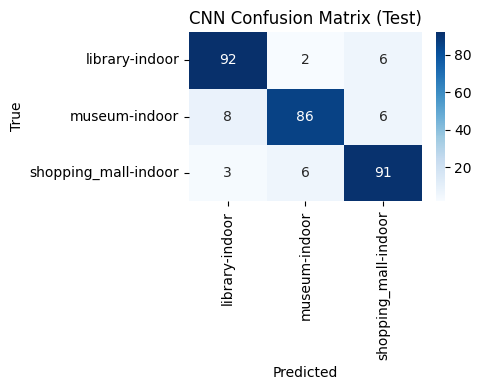

In [30]:
# Final test evaluation
best_model = CNN().to(DEVICE)
best_model.load_state_dict(torch.load(SAVE_PATH))
loss_fn = nn.CrossEntropyLoss()
te_loss,_, te_pred, te_gt = run_epoch(best_model, test_ld, loss_fn)
test_metrics = metric_dict(te_gt, te_pred)
print("\n Test metrics:", {k:f"{v:.3f}" for k,v in test_metrics.items()})
print("\nClassification Report:\n", classification_report(te_gt, te_pred, target_names=classes))

cm = confusion_matrix(te_gt, te_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("CNN Confusion Matrix (Test)")
plt.tight_layout(); plt.show()

In [ ]:
## To set the dimension size manually after flatten layer
x = torch.randn(1, 3, 256, 256).to(DEVICE)
out = model.features(x)
print(out.shape)  # e.g., [1, 128, 8, 8] → 128×8×8 = 8192

# Then update:
nn.Linear(128 * 8 * 8, 512)


torch.Size([1, 128, 16, 16])


Linear(in_features=8192, out_features=512, bias=True)

In [ ]:
@torch.no_grad()
## To test a single image on the trained/saved model
# SAVE_PATH = ""   # The saved model path
def predict_image(img_path):
    # ckpt = torch.load(SAVE_PATH, map_location=DEVICE)
    model = CNN().to(DEVICE)
    model.load_state_dict(torch.load(SAVE_PATH))
    model.eval()
    tfm = test_tfms
    img = tfm(Image.open(img_path).convert("RGB")).unsqueeze(0).to(DEVICE)
    pred = model(img).argmax(1).item()
    class_names = ["library", "museum", "shopping mall"]
    print(f"Prediction → {class_names[pred]}")

In [20]:
predict_image("Test.jpg")

Prediction → library
